In [1]:
import torch
from transformers import AdamW
from utils import get_dataloaders, get_dataset, get_cm, show_cm, pr_curve
from model_utils import train_model, model_predict
from model import TweetModel
import numpy as np
from sklearn.metrics import accuracy_score

In [3]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
batch_size = 16

In [5]:
data = get_dataset()
tensor_dataloaders = get_dataloaders(data, batch_size)

Using custom data configuration default
Reusing dataset tweets_hate_speech_detection (C:\Users\Алексей\.cache\huggingface\datasets\tweets_hate_speech_detection\default\0.0.0\c32a982d8b2d6233065d820ac655454174f8aaa8faddc74979cf793486acd3b0)


In [6]:
model = TweetModel(2)
optimizer_fn = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)
loss_fn = torch.nn.CrossEntropyLoss()

In [7]:
y_pred, y_true = model_predict(model, tensor_dataloaders['test'], device)

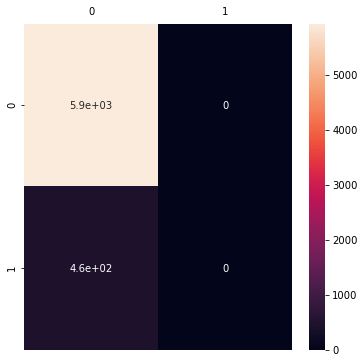

In [8]:
cm = get_cm(y_pred, y_true)
show_cm(cm)

In [9]:
print(f'Accuracy before training: {accuracy_score(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))}')

Accuracy before training: 0.9281914893617021


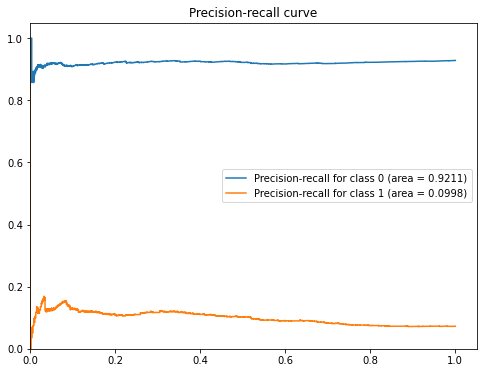

In [10]:
pr_curve(y_true, y_pred)

In [11]:
num_epochs = 3
model, best_loss_dict, best_epoch, metrics = train_model(model,
                                                         optimizer_fn,
                                                         loss_fn,
                                                         num_epochs,
                                                         tensor_dataloaders,
                                                         device)

----------
Epoch 1/3
train: loss: 4.38e-07
validation: loss: 9.84e-05
saving best model
7m 17s
----------
Epoch 2/3
train: loss: 1.52e-05
validation: loss: 1.81e-04
7m 20s
----------
Epoch 3/3
train: loss: 1.73e-05
validation: loss: 1.37e-05
saving best model
7m 22s
Best epoch: 3
best_train_loss: 1.73e-05
best_val_loss: 1.37e-05


In [12]:
y_pred, y_true = model_predict(model, tensor_dataloaders['test'], device)

In [13]:
print(f'Accuracy after training: {accuracy_score(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))}')

Accuracy after training: 0.9787234042553191


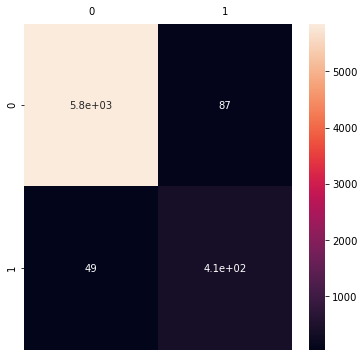

In [14]:
cm2 = get_cm(y_pred, y_true)
show_cm(cm2)

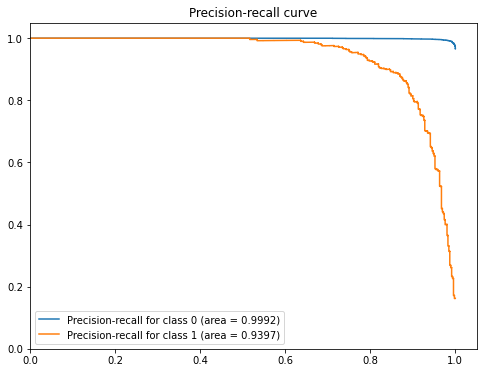

In [15]:
pr_curve(y_true, y_pred)